In [18]:
%matplotlib inline
import os
import re
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from aesthetics import params
from matplotlib import colors
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itca import bidict, itca
mpl.rcParams.update(params)
# mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# plt.rcParams.update(params)
import sys

In [3]:
#============================= Help functions =========================
def before_combine(p1, p2):
    a1 = p1  / (p1 + p2)
    a2 = p2  / (p1 + p2)
    a1 = a1 / 2
    a2 = a2 / 2
    return - a1 * p1 * np.log(p1) - a2 * p2 * np.log(p2)


def after_combine(p1, p2):
    return - (p1 + p2) * np.log(p1 + p2)


def before_combine_acc(pi, pj, sigma, d):
    p_max = max(pi, pj)
    offset = sigma**2 * np.log(p_max / (1 - pi - pj)) / np.sqrt(d)
    return norm.cdf(np.sqrt(d) / 2 + offset), norm.cdf(np.sqrt(d) / 2 - offset)


def after_combine_acc(pi, pj, sigma, d):
    offset = sigma**2 * np.log((pi + pj) / (1 - pi - pj)) / np.sqrt(d)
    return norm.cdf(np.sqrt(d) / 2 + offset), norm.cdf(np.sqrt(d) / 2 - offset)


def itca_diff_lda(p1, p2, sigma, d):
    p3 = 1 - p1 - p2
    before_acc, before_acc3 = before_combine_acc(p1, p2, sigma, d)
    after_acc, after_acc3 = after_combine_acc(p1, p2, sigma, d)
    before_itca =  - max(p1, p2) * np.log(max(p1, p2)) * before_acc  - p3 * np.log(p3) * before_acc3
    after_itca = - (p1 + p2) * np.log(p1 + p2) * after_acc  - p3 * np.log(p3) * after_acc3
    return after_itca - before_itca

In [4]:
n_points = 1000
p1_arr = np.linspace(0.001, 0.999, n_points)
canvas = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i] 
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        canvas[i, j] = after_combine(p1, p2) - before_combine(p1, p2)

In [27]:
n_points = 1000
p1_arr = np.linspace(0.001, 0.998, n_points)
canvas2 = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i]
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        if 1 - p1 - p2 > 0:
            p_max = max(p1, p2)
            canvas2[i, j] = -(p1 + p2) * np.log(p1 + p2) + max(p1, p2) * np.log(max(p1, p2))

## Figure 11: $\Delta \text{p-ITCA}$ with $S=\{1, 2\}$ of the oracle classifier (left) and LDA (right).

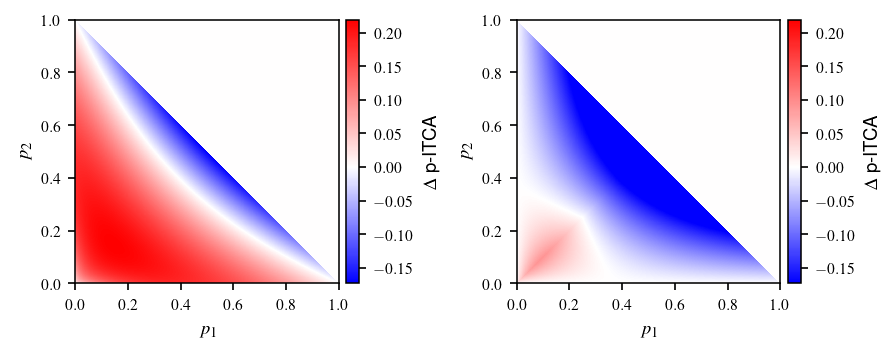

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.set_cmap('bwr')
vmin = np.min(canvas)
vmax = np.max(canvas)
color_norm = colors.TwoSlopeNorm(vmin=min(vmin, -1e-4), vcenter=0, vmax=vmax)
# plot oracle
im = ax1.pcolormesh(p1_arr, p1_arr, canvas, norm=color_norm, shading='auto')
ax1.set_aspect(1.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel("$p_1$")
ax1.set_ylabel("$p_2$")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ p-ITCA")
# plot LDA
im = ax2.pcolormesh(p1_arr, p1_arr,  canvas2, norm=color_norm, shading='auto')
ax2.set_aspect(1.0)
ax2.set_xlabel("$p_1$")
ax2.set_ylabel("$p_2$")
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ p-ITCA")
fig.set_size_inches(6, 3)
plt.tight_layout()

## Figure 12: $\Delta \text{s-ITCA}$ with $K_0=3$, $S=\{1, 2\}$ of LDA (middle panel) and the soft LDA (right panel).

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.special import softmax
from tqdm import tqdm
from itca.simulation_suites import lda_suite
from itca.search import GreedySearch
from itca.utils import compute_hamming_distance, compute_y_dist
from itca.metrics import itca
from itertools import product

def vectorized(prob_matrix, items):
    s = prob_matrix.cumsum(axis=1)
    r = np.random.rand(prob_matrix.shape[0])
    k = (s < r[:, np.newaxis]).sum(axis=1)
    return items[k]

class SoftLDA(LinearDiscriminantAnalysis):
    def predict(self, X):
        score = self.decision_function(X)
        if score.ndim == 1:
            return np.zeros(X.shape[0], dtype=int)
        prob_matrix = softmax(score, axis=1)
        vals = np.arange(X.shape[0],dtype=int)
        y_pred = vectorized(prob_matrix, vals)
        return y_pred
    
def split_class(y, label, prop=0.5, seed=None):
    np.random.seed(seed)
    ind = y == label
    yi = y[ind]
    yi[np.random.rand(yi.shape[0]) <= prop] = np.max(y) + 1
    y_ = np.copy(y)
    y_[ind] = yi
    return y_  

def compute_hamming_dist(bv1, bv2):
    assert(len(bv1) == len(bv2))
    a = [bv1[i] == bv2[i] for i in range(len(bv1))]
    return len(bv1) - np.sum(a)

    
def mapping2bv(mapping):
    bv = [int(mapping[i] != mapping[i-1]) for i in range(1, len(mapping))]
    return "".join(str(b) for b in bv)

def compute_diff(X, y_obs, y_true, clf, id_mapping, true_mapping, y_dist):
    clf.fit(X, y_obs)
    prior = itca(y_obs, clf.predict(X), id_mapping, y_dist)
    clf.fit(X, y_true)
    post = itca(y_obs, clf.predict(X), true_mapping, y_dist)
    return post - prior

In [19]:
n_points = 100
protect = 0.1
p1_arr = np.linspace(0.1, 0.9, n_points)
n_samples = 5000
repeat = 10
canvas_hard = np.zeros([n_points, n_points])
canvas_soft = np.zeros([n_points, n_points])
lda = LinearDiscriminantAnalysis()
soft_lda = SoftLDA()
id_mapping = bidict({0:0, 1:1, 2:2, 3:3})
true_mapping = bidict({0:0, 1:1, 2:2, 3:2})
for i, j in tqdm(product(range(len(p1_arr)), range(len(p1_arr))), total=n_points**2):
        p1 = p1_arr[i]
        p2 = p1_arr[j]
        ni = int(n_samples * (1 - p1 - p2) / 2)
        if ni > protect * n_samples:
            hard_diff_v = []
            soft_diff_v = []
            for _ in range(repeat):
                sim_data = lda_suite(np.array([ni, ni, int((p1 + p2) * n_samples)]), p=4, 
                             n_classes=3, length=5, seed=0, min_dist=1)
                X = sim_data.X.T
                y_true = sim_data.y
                y_obs = split_class(sim_data.y, 2, prop=p1 / (p1 + p2))
                y_dist = compute_y_dist(y_obs)
                hard_diff = compute_diff(X, y_obs, y_true, lda, id_mapping, true_mapping, y_dist)
                soft_diff = compute_diff(X, y_obs, y_true, soft_lda, id_mapping, true_mapping, y_dist)
                hard_diff_v.append(hard_diff)
                soft_diff_v.append(soft_diff)
            canvas_hard[i, j] = np.mean(hard_diff_v)
            canvas_soft[i, j] = np.mean(soft_diff_v) 

100%|██████████| 10000/10000 [16:02<00:00, 10.38it/s]


In [34]:
p1_arr_ = np.linspace(0.001, 0.999, n_points)
ind_end = np.argmin(np.abs(p1_arr_ - 0.7))
ind_start = np.argmin(np.abs(p1_arr_ - 0.1))
canvas2_sub = canvas2[ind_start:ind_end+1, ind_start:ind_end+1]
p1_arr_sub = p1_arr_[ind_start:ind_end+1]
mask = np.flip(np.tril(np.ones(canvas2_sub.shape)), axis=0)

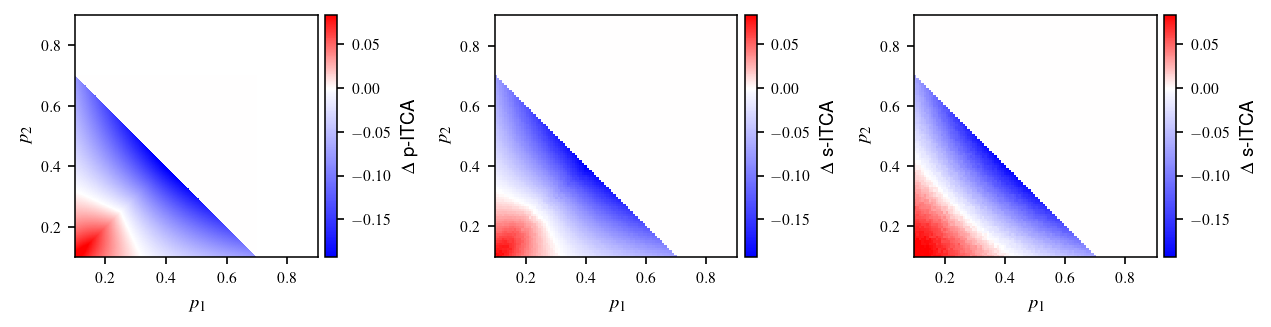

In [42]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
p1_arr = np.linspace(0.1, 0.9, 100)
vmin = min(np.min(canvas_hard), np.min(canvas_soft))
vmax = min(np.max(canvas_hard), np.max(canvas_soft))
color_norm = matplotlib.colors.TwoSlopeNorm(vmin=min(vmin, -1e-4), vcenter=0, vmax=vmax)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
plt.set_cmap('bwr')
ax0.set_aspect(1.0)
#-------------------------------  Plot p-ITCA for comparision -----------------------------------
im0 = ax0.pcolormesh(p1_arr_sub, p1_arr_sub,  np.multiply(canvas2_sub, mask), 
                     norm=colors.TwoSlopeNorm(vmin=-0.18, vcenter=0, vmax=0.08),
                     shading='auto')
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ p-ITCA")
ax0.set_aspect(1.0)
ax0.set_xlim([0.1, 0.9])
ax0.set_ylim([0.1, 0.9])
ax0.set_xlabel("$p_1$")
ax0.set_ylabel("$p_2$")
#------------------------------- plot LDA --------------------------------------
im1 = ax1.pcolormesh(p1_arr, p1_arr,  canvas_hard, norm=color_norm,
                    shading='auto')
ax1.set_aspect(1.0)
ax1.set_xlabel("$p_1$")
ax1.set_ylabel("$p_2$")
#------------------------------- plot soft LDA ---------------------------------
im2 = ax2.pcolormesh(p1_arr, p1_arr,  canvas_soft, norm=color_norm,
                    shading='auto')
ax2.set_xlabel("$p_1$")
ax2.set_ylabel("$p_2$")
ax2.set_aspect(1.0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ s-ITCA")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im2, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ s-ITCA")
fig.set_size_inches(8.5, 3)
plt.tight_layout()